---
layout: code-post
title: Pedicting rooting interests on reddit
description: Going to see if we can predict neutral fan rooting interests from reddit posts.
tags: [neural nets]
---

In this notebook / post I'm going to try to see if we can predict who a
supposedly neutral fan is rooting for in the (as of this writing) about to
end Lakers-Heat NBA finals. To do this, I'm going to attempt to scrape posts
from game threads by Heat and Lakers fans to train an LSTM based model. As long
as I can scrape the flair from from the reddit API, this should be doable. If
not, then I will have to scrape from the team specific subreddits and try that
way.

I'm going to write the disclaimer here: I don't think I'll find much signal in
these posts. Many of the posts will be pretty neutral, so it'll be hard to
distinguish fans based off a single post. The most likely scenario to me is that
it picks up on the player names for each team and guess based on that which 
might work for a game not between the two teams. But let's find out! I'm going
to commit the notebook with this caveat first (check the commits!).

Outline:
- Data Collection
  - PRAW - Exploring Reddit
  - Pushshift - Gathering data
  - Preparing to clean - Data exploration
  - Cleaning and saving data
- Modeling
  - Dataset
  - Model
  - Training
- Test set predictions
  - Get and predict test set
  - Explore posts and users

## Data Collection

If you don't know what [reddit](https://reddit.com/) is, it's a website that is
organized into communities called _subreddits_. The site has _users_ which belong to
multiple subreddits. Each subreddit contains a sequence of _submissions_ (also called
_posts_) which can be links
to other sites, images, or text. Each post contains _comments_ which are text only
an are made by the users. The _comment section_ is organized as a forest of trees
wich top level comments and then comments nested below each top level comment. Each
user can have a _flair_ which varies with the subreddit they are posting in. The
flair and username are posted along with each comment. The flair will contains a
small image as well as text. Not every user has a flair associated to it for every
subreddit to which they belong. It is not always required to be a member of the
subreddit in order to post, although this varies by community.

We will be using the NBA subreddit which as of this writing has ~3.5 million users.
Users in this subreddit have flairs which denote which team the user is a supporter
of. Mine is for the Cleveland Cavaliers.

### PRAW - Exploring Reddit

In order to access reddit, we need to have a reddit account and then create an application
with that account as a developer of the application. Go to [the apps page](https://www.reddit.com/prefs/apps)
to create an application. (Please read the terms and conditions!)
You need to store the name of the app as the `user_agent`, the
`client_id` is the 14 character string that is below the app name once it's created, 
you'll have a 27 character secret secret that is generated and is the `client_secret`, 
and you'll need your `username`. I have put these credentials in an encrypted YAML file
that I created using ansible-vault.

We will be using [PRAW](https://github.com/praw-dev/praw), the Python Reddit API
Wrapper.

In [279]:
import praw
import yaml
from ansible_vault import Vault
from getpass import getpass

In [10]:
vault = Vault(getpass())
with open('redditcreds.yml', 'r') as f:
    reddit_creds = vault.load(f.read())

reddit = praw.Reddit(username=reddit_creds['username'],
                     user_agent=reddit_creds['user_agent'],
                     client_id=reddit_creds['client_id'],
                     client_secret=reddit_creds['client_secret'])

 ····················


Now we get into the [NBA subreddit](https://www.reddit.com/r/nba) and search for posts which are _game threads_
to which users will post while a game is ongoing. These are posted automatically and so they have a 
predictible title format which makes searching for them and then filtering the received submisisons
by title easier.

In [76]:
subreddit = reddit.subreddit('nba')

submissions = subreddit.search(query='title:"GAME THREAD"',
                               time_filter="month")
game_threads = [
    s for s in submissions 
    if
        s.title[:11] == 'GAME THREAD' 
        and ("Lakers" in s.title or "Heat" in s.title)
]

In [77]:
for t in game_threads:
    print(t.title)

GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (October 09, 2020)
GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (September 30, 2020)
GAME THREAD: Los Angeles Lakers (52-19) @ Miami Heat (44-29) - (October 06, 2020)
GAME THREAD: Los Angeles Lakers (52-19) @ Miami Heat (44-29) - (October 04, 2020)
GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (October 02, 2020)
GAME THREAD: Denver Nuggets (46-27) @ Los Angeles Lakers (52-19) - (September 26, 2020)
GAME THREAD: Los Angeles Lakers (52-19) @ Denver Nuggets (46-27) - (September 24, 2020)
GAME THREAD: Los Angeles Lakers (52-19) @ Denver Nuggets (46-27) - (September 22, 2020)
GAME THREAD: Denver Nuggets (46-27) @ Los Angeles Lakers (52-19) - (September 18, 2020)
GAME THREAD: Boston Celtics (48-24) @ Miami Heat (44-29) - (September 27, 2020)
GAME THREAD: Denver Nuggets (46-27) @ Los Angeles Lakers (52-19) - (September 20, 2020)
GAME THREAD: Miami Heat (44-29) @ Boston Celtics (48-24) - (Septembe

The comments for a submission are contained in PRAW `CommentForest`. If we do not
care about the structure, we can flatten this to a list. Note that the list
will contain both `Comment` objects as well as `MoreComments` objectcs. It is possible to replace
the `MoreComments` objects using the `replace_more` function, but each replacement
requires calling the reddit API. By default, 32 of the `MoreComments` objects will
be replaced, which I will keep but I will also limit to those which contain at least
5 more comments in them. Doing this removes all `MoreComments` instances from
the list of comments.

In [93]:
game_thread = game_threads[0]
print(game_thread.title)
print("number of comments:", game_thread.num_comments)
game_thread.comments.replace_more(limit=32, threshold=5)
comments = game_thread.comments.list()

GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (October 09, 2020)
number of comments: 28455


And here is a random comment:

In [168]:
c = comments[10]
print('comment author:   ', c.author.name)
print('comment score:    ', c.score, '({}-{})'.format(c.ups, c.downs))
print('author flair text:', c.author_flair_text)
print('body:\n\n', c.body)

comment author:    StoneColdAM
comment score:     28 (28-0)
author flair text: Lakers
body:

 Dwight Howard strategy: get Jimmy Butler ejected.


For the training set, the goal will be to find authors which are flaired as Lakers or Heat or have
flair text that contains LAL or MIA.

In [178]:
lakers_comments = [
    c for c in comments
    if
        c.author_flair_text is not None
        and (
            c.author_flair_text == 'Lakers'
            or '[LAL]' in c.author_flair_text
        )
]
print('number of comments by Lakers users:', len(lakers_comments))

heat_comments = [
    c for c in comments
    if
        c.author_flair_text is not None
        and (
            c.author_flair_text == 'Heat'
            or '[MIA]' in c.author_flair_text
        )
]
print('number of comments by Heat users  :', len(heat_comments))

number of comments by Lakers users: 1042
number of comments by Heat users  : 275


### Pushshift - Gathering data

It turns out that PRAW is fairly limited and the [Pushshift API](https://github.com/pushshift/api) is
more powerful than it. There is a wrapper for this API called [PSAW](https://github.com/dmarx/psaw).
PSAW and PRAW interact with each other nicely: if you pass a PRAW `Reddit` instance to PSAW's
`PushShiftAPI` class, pushshift gathers the IDs you want but then returns PRAW objects.

In [274]:
from psaw import PushshiftAPI
import datetime as dt

api = PushshiftAPI(reddit)

# we'll search month by month for submissions
game_threads = []

months = [
    int(dt.datetime(2019, 10, 19).timestamp()),
    int(dt.datetime(2019, 11, 1).timestamp()),
    int(dt.datetime(2019, 12, 1).timestamp()),
    int(dt.datetime(2020, 1, 1).timestamp()),
    int(dt.datetime(2020, 2, 1).timestamp()),
    int(dt.datetime(2020, 3, 1).timestamp()),
    int(dt.datetime(2020, 4, 1).timestamp()),
    int(dt.datetime(2020, 5, 1).timestamp()),
    int(dt.datetime(2020, 6, 1).timestamp()),
    int(dt.datetime(2020, 7, 1).timestamp()),
    int(dt.datetime(2020, 8, 1).timestamp()),
    int(dt.datetime(2020, 9, 1).timestamp()),
    int(dt.datetime(2020, 10, 1).timestamp()),
    int(dt.datetime(2020, 11, 1).timestamp())
]

for i in range(len(months)-1):
    submissions = list(api.search_submissions(after=months[i],
                                              before=months[i+1],
                                              q='game thread',
                                              subreddit='nba',
                                              author='NBA_MOD',
                                              limit=5000))
    
    game_threads += [
        s for s in submissions
        if
            s.title[:11] == 'GAME THREAD'
            and ("Lakers" in s.title or "Heat" in s.title)
    ]

Now that we have game threads, it's time to collect relevant comments from each game.
We'll be using PRAW for this.

In [504]:
from IPython.display import clear_output

lakers_comments = []
heat_comments = []

num_game_threads = len(game_threads)
i = 1

def check_lakers(comment):
    if comment.author_flair_text is not None:
        if comment.author_flair_text == 'Lakers':
            return True
        if '[LAL]' in comment.author_flair_text:
            return True
    return False

def check_heat(comment):
    if comment.author_flair_text is not None:
        if comment.author_flair_text == 'Heat':
            return True
        if '[MIA]' in comment.author_flair_text:
            return True
    return False

for game_thread in game_threads:
    
    clear_output(wait=True)
    print('scouring game thread: {}/{}'.format(i, num_game_threads))
    print('number of lakers comments:', len(lakers_comments))
    print('  number of heat comments:', len(heat_comments))
    
    has_lakers = 'Lakers' in game_thread.title
    has_heat = 'Heat' in game_thread.title
    
    # NOTE: this part takes a long time
    game_thread.comments.replace_more(limit=32, threshold=2)
    comments = game_thread.comments.list()
    
    if has_lakers and has_heat:
        lakers = []
        heat = []
        
        for c in comments:
            if check_lakers(c) and len(c.body.split()) > 3:
                lakers += [c]
            elif check_heat(c) and len(c.body.split()) > 3:
                heat += [c]
                
        lakers_comments += lakers
        heat_comments += heat
        
    elif has_lakers:
        lakers =[]
        
        for c in comments:
            if check_lakers(c) and len(c.body.split()) > 3:
                lakers += [c]
                
        lakers_comments += lakers
      
    elif has_heat:
        heat = []
        
        for c in comments:
            if check_heat(c) and len(c.body.split()) > 3:
                heat += [c]
                
        heat_comments += heat
        
    i += 1

scouring game thread: 180/180
number of lakers comments: 47535
  number of heat comments: 12907


In [505]:
import pickle

with open('data/lakers_comments.pkl', 'wb') as f:
    pickle.dump(lakers_comments, f)
    
with open('data/heat_comments.pkl', 'wb') as f:
    pickle.dump(heat_comments, f)

### Perparing to clean - data exploration

Cleaning text is tedious and many people have already though about what to do. 
I am taking code from [this blog post](https://hub.packtpub.com/clean-social-media-data-analysis-python/).
The cleaning we're doing is just about replacing weird and unwanted characters and then
lemmatizing.

I have played around with the stop words a bit. Since this is really a form of
sentiment analysis, I put back in the negations. Since this is basketball, I also
want numbers such as two and three to be allowed. I want some ofthe directions like
up and down and over and under.

Since I'm going to use spaCy's vector encoding for the words instead of a dummy
one-hot encoding, I thought about replacing the player names with a placeholder
such as `heatplayer`, but this appears to be mostly unnecessary, as the vectorizer
that is build in already knows names such as `lebron`. One can confirm this with
`nlp('lebron')[0].vector` and see it is not hte zero vector.

In [1]:
# let's reload things as needed

import pickle

with open('data/lakers_comments.pkl', 'rb') as f:
    lakers_comments = pickle.load(f)
    
with open('data/heat_comments.pkl', 'rb') as f:
    heat_comments = pickle.load(f)

In [2]:
import re
import itertools
import spacy

nlp = spacy.load('en_core_web_lg')

regexes = {
    'weird_chars': re.compile(r'[\?;\(\)\\.,\!:–\-\"\[\]“”]'),
    'newlines': re.compile(r'\n'),
    'html': re.compile(r'<[^<]+/>', re.MULTILINE),
    'urls': re.compile(r'^https?://.*[rn]*', re.MULTILINE),
    'spaces': re.compile(r'\s{2,}'),
    'u': re.compile(r'\bu\b')
}

allowed_stops = ['no', 'never', 'not', 'none', 'up', 'down', 
                 'back', 'over', 'under', 'two', 'three']
stop_words = [
    word for word in nlp.Defaults.stop_words 
    if word not in allowed_stops
]
stop_words += ['-PRON-']

def clean_text(text):
    """ substitute things based on the regexes above """
    text = text.lower()
    
    # custom replacements we decided on
    text = text.replace('`', '\'')
    text = text.replace('’', '\'')
    
    text  = text.replace("won't", "will not")
    text  = text.replace("n't", " not")
    
    text = regexes['u'].sub('you', text)
    text = regexes['html'].sub(' ', text)
    text = regexes['urls'].sub(' ', text)
    text = regexes['weird_chars'].sub(' ', text)
    text = regexes['newlines'].sub(' ', text)
    text = regexes['spaces'].sub(' ', text)
    
    # removing the multiletters such as 'happppy' -> 'happy'
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    
    # lemmatize
    text = ' '.join([word.lemma_ for word in nlp(text)])
    
    # remove stopwords
    text = ' '.join([w for w in text.split(' ') if w not in stop_words])
    
    return text

Now let's just print some examples of what we end up with when cleaning the text:

In [3]:
def print_cleantext(text):
    print('|', text)
    print('|\t\t-----------')
    print('|',clean_text(text))

print_cleantext(heat_comments[50].body)
print('\n\n')
print_cleantext(heat_comments[1047].body)
print('\n\n')
print_cleantext(lakers_comments[500].body)
print('\n\n')
print_cleantext(lakers_comments[-200].body)
print('\n\n')
print_cleantext(lakers_comments[14477].body)

| He's coming back from an injury.
|		-----------
| come back injury



| Y'all thought that we were joking about the championship?
|		-----------
| think joke championship



| Flagrant 2 requires it to be excessively violent, which it pretty clearly wasn’t. Easy flagrant 1 call
|		-----------
| flagrant 2 require excessively violent pretty clearly not easy flagrant 1



| Get AD back in pls
|		-----------
| ad back pls



| Are we going to win a fucking championship? I can't believe this. I thought the warriors would be on top forever (and then some).
|		-----------
| win fucking championship not believe think warrior forever


### Cleaning and saving data

Now we do initiate the (long?) work of converting the comments into vectors which we
can then save. We have approximately 60,000 comments total. Just for a ballpark estimate,
let's suppose there are 10 words per comment. Thus we need to store about 600k vectors.
How much space does each vector take? We can figure out as follows:

In [571]:
import sys

vector_size = sys.getsizeof(nlp('lebron')[0].vector)
print('Vector size in bytes:', vector_size)
print('Estimate size to store:', vector_size * 600_000 / 1e6, 'MB')

Vector size in bytes: 96
Estimate size to store: 57.6 MB


This is well within our ability to store things in memory or on disk even if we were off in our average comment size
by a factor of ten, so no worries there for this application. We'll store the data as a list of tuples where each
tuple contains both a numpy array of shape (n, 300) where n is the number of words in the comment and a 0 or 1
depending on if the comment is from a Heat fan (0) or a Lakers fan (1). Previously we guaranteed that the comments
had a certain length, but stop word removal will shorten comments, so we will drop some comments here if there are 
not enough words after cleaning.

In [4]:
import numpy as np

def comment_to_numpy_array(comment, min_words=3):
    
    # first step is to clean the comment
    clean_comment = clean_text(comment)
    
    # next is to get an nlp object
    nlp_comment = nlp(clean_comment)
    
    # get nonzero vectors
    word_vectors = [
        word.vector for word in nlp_comment
        if np.count_nonzero(word.vector) > 0
    ]
    
    # return sufficiently long comments
    if len(word_vectors) >= min_words:
        return word_vectors
    else:
        return None

In [598]:
initial_lakers_comments = [
    comment_to_numpy_array(comment.body) for comment in lakers_comments
]

lakers_vector_comments = [
    (comment, 1) for comment in initial_lakers_comments
    if comment is not None
]

with open('data/lakers_vector_comments.pkl', 'wb') as f:
    pickle.dump(lakers_vector_comments, f)

initial_heat_comments = [
    comment_to_numpy_array(comment.body) for comment in heat_comments
]

heat_vector_comments = [
    (comment, 0) for comment in initial_heat_comments
    if comment is not None
]
    
with open('data/heat_vector_comments.pkl', 'wb') as f:
    pickle.dump(heat_vector_comments, f)

The actual sizes of these files on disk were 96 MB for the Heat comments and 347 MB for the Lakers comments.

## Modeling

Now we go through the modeling process, by which we mean the process of using PyTorch to build 
and train a model to predict whether a post is by a Lakers fan or by a Heat fan.

### Dataset

This section is about creating a PyTorch `Dataset` that loads the data
that we scraped from Reddit and cleaned in the data collection section. Data cleaning
is data modeling, while what we do here is not.

We will try to use the `WeightedRandomSampler` (with replacement) so that we can return
comments from Lakers and Heat fans with equal probability even though the two
classes are imbalanced.

In [6]:
# again, we load in what we saved if we need to

import pickle

with open('data/lakers_vector_comments.pkl', 'rb') as f:
    lakers_vector_comments = pickle.load(f)
    
with open('data/heat_vector_comments.pkl', 'rb') as f:
    heat_vector_comments = pickle.load(f)

In [200]:
import torch
from torch.utils.data import Dataset

class TrainDataset(Dataset):
    
    def __init__(self, lakers_vector_comments, heat_vector_comments):
        """ we will combine the two datasets into one dataset"""
        
        self._len_lakers = len(lakers_vector_comments)
        self._len_heat = len(heat_vector_comments)
        
        self._samples = [
            torch.tensor(c[0]) for c in lakers_vector_comments + heat_vector_comments
        ]
        self._labels = [
            torch.tensor(c[1]) for c in lakers_vector_comments + heat_vector_comments
        ]
        
    @property
    def len_lakers(self):
        return self._len_lakers
    
    @property
    def len_heat(self):
        return self._len_heat
    
    @property
    def samples(self):
        return self._samples
    
    @property
    def labels(self):
        return self._labels
        
    def __len__(self):
        return self.len_lakers + self.len_heat
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.samples[idx], self.labels[idx]
    
training_data = TrainDataset(lakers_vector_comments, heat_vector_comments)

In [206]:
training_data[0][0]

tensor([[-0.2179,  0.4413, -0.4320,  ..., -0.1647,  0.3225,  0.3058],
        [-0.7036,  0.1382,  0.6530,  ..., -0.1667, -0.0218,  0.3645],
        [ 0.6381, -0.2333,  0.2290,  ..., -0.0055, -0.4417, -0.2157],
        ...,
        [ 0.3504,  0.1946, -0.4185,  ...,  0.5152,  0.0354, -0.1521],
        [ 0.5428, -0.2805,  0.7388,  ..., -0.1633, -0.4704,  0.1079],
        [-0.5329, -0.2012, -0.0371,  ..., -0.0696,  0.0811,  0.2704]])

Now we set up the sampler so that it chooses Lakers and Heat comments with equal probability.
We do this because we expect (foolishly, probably) that comments by neutral fans on game
threads are equally likely to be for the Lakers as for the Heat. This is almost certainly
false since LeBron plays for the Lakers and is undoubtedly the most popular player in
the league, but we'll use this assumption for now.

In [207]:
from torch.utils.data.sampler import WeightedRandomSampler

lakers_weight = training_data.len_heat / len(training_data)
heat_weight = training_data.len_lakers / len(training_data)

weights = np.concatenate([
    lakers_weight * np.ones(training_data.len_lakers),
    heat_weight * np.ones(training_data.len_heat)
])

sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

Finally, we create a `DataLoader` to give use random samples. We will not be doing batches, since I'm 
unsure how to do that with samples of different lengths without padding the shorter comments, which I
have decided not to do out of inertia.

In [208]:
from torch.utils.data import DataLoader

train_loader = DataLoader(training_data,
                          batch_size=1,
                          shuffle=False, # required by sampler type
                          sampler=sampler)

### Create the Model

And now we create our LSTM based model to predict whether a comment comes from a Lakers fan or a Heat fan.

It seems to be an open question of how large the hidden state should be in an LSTM. It seems that some number
between the input and output layers should work and ultimately this is something that would need to be
optimized for on a validation set. I'm not going to bother with that and just set it to be 128, i.e., a power of
2 that is just under half of the input size and hope that works out well enough. Some discussions can be found on [stackexchange](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/136542#136542)
and [quora](https://www.quora.com/In-LSTM-how-do-you-figure-out-what-size-the-weights-are-supposed-to-be) so take
that how you want, dear reader. The PyTorch LSTM docs are [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

In [223]:
import torch.nn as nn

class BasketballNet(nn.Module):

    def __init__(self, random_state=47):
        super(BasketballNet, self).__init__()
        torch.manual_seed(random_state)
        
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=128,
                            num_layers=1,
                            bias=True)
        self.to_out = nn.Linear(128, 1)
        
        
    def forward(self, x):
        """ Non-batched for a sequence with n words the
        input needs to have shape (n, 1, 300).
        We put in sequences of size (n, 300) which
        we can change with a view.
        
        We will pass in the entire sequence at once,
        but one can also iterate through one word at a
        time. This would allow for a truncated backprop
        through time since one could zero out the state
        partway through. We won't be doing this. """
        
        lstm_out, _ = self.lstm(x.view(x.shape[0], 1, -1))
        raw_out = self.to_out(lstm_out[x.shape[0]-1])
        out = torch.sigmoid(raw_out)
        
        return out

Let's show that this does in fact work by just feeding it some random input of the correct size
and getting an output from it. That's it, that's the test. It's how I made sure it was working
and fixed some typos.

In [224]:
basketball_net = BasketballNet()
random_input = torch.randn(5, 300)
test_out = basketball_net(random_input)
print('random output from random input:', test_out)

random output from random input: tensor([[0.5075]], grad_fn=<SigmoidBackward>)


### Training

Now let's train. We'll use ADAM to optimize and mean square error loss. We're not
going too crazy here, ya know. I'll probably write this elsewhere in this post, but 
I don't think we're going to get great results. This is because fundamentally I don't
believe that there's much signal in the training examples and that this is a hard
problem.

In [274]:
from torch.optim import Adam

basketball_net = BasketballNet()
optimizer = Adam(basketball_net.parameters())
criterion = nn.MSELoss()

In [275]:
num_wrong = 0.0
for sample, label in training_data:
    output = basketball_net(sample)
    
    if output[0][0] >= 0.5:
        prediction = 1.0
    else:
        prediction = 0.0
        
    if np.abs(prediction - label.item()) > 0:
        num_wrong += 1
        
print('initial training error rate: {:.3f}'.format(num_wrong / len(training_data)))

initial training error rate: 0.655


In [276]:
for epoch in range(10): 

    running_loss = 0.0
    num_wrong = 0.0
    num_lakers = 0.0
    num_heat = 0.0
    for sample, label in train_loader:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = basketball_net(sample[0])
        loss = criterion(output.float(), label.float())
        loss.backward()
        optimizer.step()

        if output[0][0] >= 0.5:
            prediction = 1
        else:
            prediction = 0
            
        if int(label.item()) == 1:
            num_lakers += 1
        else:
            num_heat += 1
        
        num_wrong += np.abs(prediction - label.item())
        running_loss += loss.item()
        
    class_error = num_wrong / len(train_loader)
    rate_lakers = num_lakers / (num_lakers + num_heat)
    print('epoch: {} - loss: {:.3f} - classification error: {:.3f} - rate lakers: {:.3f}'.format(epoch+1,
                                                                                                 loss,
                                                                                                 class_error,
                                                                                                 rate_lakers))
    
    if class_error == 0.0:
        break

print('Finished Training')

epoch: 1 - loss: 0.251 - classification error: 0.217 - rate lakers: 0.497
epoch: 2 - loss: 0.736 - classification error: 0.143 - rate lakers: 0.503
epoch: 3 - loss: 0.000 - classification error: 0.111 - rate lakers: 0.498
epoch: 4 - loss: 0.253 - classification error: 0.088 - rate lakers: 0.499
epoch: 5 - loss: 0.001 - classification error: 0.076 - rate lakers: 0.498
epoch: 6 - loss: 0.000 - classification error: 0.069 - rate lakers: 0.497
epoch: 7 - loss: 0.000 - classification error: 0.064 - rate lakers: 0.500
epoch: 8 - loss: 0.000 - classification error: 0.059 - rate lakers: 0.502
epoch: 9 - loss: 0.009 - classification error: 0.056 - rate lakers: 0.500
epoch: 10 - loss: 0.000 - classification error: 0.055 - rate lakers: 0.498
Finished Training


This certainly looks like overtraining to me. The random samples do give weird things like
the loss fluctuating so much.  Let's seee what the overall error rate is.

In [277]:
num_wrong = 0.0
for sample, label in training_data:
    output = basketball_net(sample)
    
    if output[0][0] >= 0.5:
        prediction = 1.0
    else:
        prediction = 0.0
        
    if np.abs(prediction - label.item()) > 0:
        num_wrong += 1
        
print('final training error rate: {:.3f}'.format(num_wrong / len(training_data)))

final training error rate: 0.057


At least the error rate didn't shoot up, but the model has probably seen almost all the Lakers samples by this point.
I've thought about re-training and stopping after a couple epochs, but I think I'll just roll with what we've got
and see what the reuslts look like.

## Analysis of neutral fans

For the "test set" we're going to take the comments from neutral fans during the finals between the Lakers
and Heat and do some analysis. Since these comments don't have labels, this isn't really a test set, it's
just we're going to see what sort of (flawed!) analysis we can do with this overfit model.
 
Before doing that, let's play around with some comments that we made.

In [597]:
comments = [
    "Lebron is the goat basketball player",
    "Lebron is terrible. He flops. I hate him. Jordan is better",
    "Jimmy Butler tries harder than everyone he deserves this",
    "Duncan Robinson is a great shooter Lakers can't stop us",
    "Jimmy and LeBron are the two best players out there",
    "LeBron and Jimmy are the two best players out there",
    "Wow, what a three pointer! On fire tonight",
    "Mark Jackson is the worst. Need to change commenters next year please",
    "good good good",
    "bad bad bad",
    "lakers heat lakers heat",
    "heat lakers heat lakers",
    "neutral netural neutral",
    "neutral comment without bias"
]

for comment in comments:
    text_array = comment_to_numpy_array(comment)
    predict_proba = basketball_net(torch.tensor(text_array)).item() * 100

    if predict_proba >= 50:
        prediction = "Lakers"
    else:
        prediction = "Heat"
        predict_proba = 100 - predict_proba
    
    print("'" + comment +"': {} ({:.1f}%)\n".format(prediction, predict_proba))

'Lebron is the goat basketball player': Lakers (100.0%)

'Lebron is terrible. He flops. I hate him. Jordan is better': Lakers (86.1%)

'Jimmy Butler tries harder than everyone he deserves this': Heat (99.9%)

'Duncan Robinson is a great shooter Lakers can't stop us': Heat (72.1%)

'Jimmy and LeBron are the two best players out there': Heat (82.2%)

'LeBron and Jimmy are the two best players out there': Heat (71.1%)

'Wow, what a three pointer! On fire tonight': Lakers (98.5%)

'Mark Jackson is the worst. Need to change commenters next year please': Heat (91.6%)

'good good good': Lakers (83.2%)

'bad bad bad': Heat (92.6%)

'lakers heat lakers heat': Lakers (75.6%)

'heat lakers heat lakers': Heat (94.3%)

'neutral netural neutral': Heat (100.0%)

'neutral comment without bias': Heat (57.9%)



Order obviously matters (see the last two comments). It mostly seems to be identifying 
players on each team, which is pretty cool! But also flawed, as you can see in the second
comment which is critical of LeBron but still identifies the comment as being from a 
pro-Lakers fan. The percentages are also really high, which seems to indicate overfitting.
It's funny to me that "good good good" is a Lakers comment while "bad bad bad" is predicted
as a Heat comment. Maybe Heat fans were more negative overall this year? There certainly wasn't
as much optimism surrounding them going into the season and Lakers fans are rather notoriously
smug.

### Get comments and predict

That was fun, but let's now get the set of comments we want to analyze on.

In [280]:
vault = Vault(getpass())
with open('redditcreds.yml', 'r') as f:
    reddit_creds = vault.load(f.read())

reddit = praw.Reddit(username=reddit_creds['username'],
                     user_agent=reddit_creds['user_agent'],
                     client_id=reddit_creds['client_id'],
                     client_secret=reddit_creds['client_secret'])

 ····················


In [286]:
subreddit = reddit.subreddit('nba')

submissions = subreddit.search(query='title:"GAME THREAD"',
                               time_filter="month")
game_threads = [
    s for s in submissions 
    if
        s.title[:11] == 'GAME THREAD' 
        and ("Lakers" in s.title and "Heat" in s.title)
]

for s in game_threads:
    print(s.title)

GAME THREAD: Los Angeles Lakers (52-19) @ Miami Heat (44-29) - (October 11, 2020)
GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (October 09, 2020)
GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (September 30, 2020)
GAME THREAD: Los Angeles Lakers (52-19) @ Miami Heat (44-29) - (October 06, 2020)
GAME THREAD: Los Angeles Lakers (52-19) @ Miami Heat (44-29) - (October 04, 2020)
GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (October 02, 2020)


It was easy enough to get the comments with PRAW, so no need to rely on pushshift for this task.
Now let's try to aggregate comments by user. First we have to realize more 
of the comments, though we won't do all of them. Recall that this takes awhile as we
make repeated calls to the reddit API.

In [287]:
for game_thread in game_threads:
    game_thread.comments.replace_more(limit=32, threshold=0)

Let's get the comments that we care about, i.e., for users that are 

In [444]:
from time import sleep

def valid_user(flair):
    
    # want to ensure that user is flaired
    if flair is None:
        return False
    
    flair = flair.lower()
    
    if 'lal' in flair or 'mia' in flair \
        or 'lakers' in flair or 'heat' in flair:
        return False
    else:
        return True
    
prediction_data = []

for game in game_threads:
    
    print(game.title)
    game_id = game.id
    
    for comment in game.comments:
        
        try:
            author_id = comment.author.id
            flair = comment.author_flair_text
            comment_id = comment.id
        except AttributeError:
            continue
            
        if valid_user(flair):
            text_array = comment_to_numpy_array(comment.body)

            if text_array is not None and len(text_array) >= 3:
                predict_proba = basketball_net(torch.tensor(text_array)).item()
                
                if predict_proba >= 0.5:
                    prediction = 1
                else:
                    prediction = 0
                
                prediction_data += [(
                    game_id,
                    author_id,
                    comment_id,
                    predict_proba,
                    prediction
                )]

GAME THREAD: Los Angeles Lakers (52-19) @ Miami Heat (44-29) - (October 11, 2020)
GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (October 09, 2020)
GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (September 30, 2020)
GAME THREAD: Los Angeles Lakers (52-19) @ Miami Heat (44-29) - (October 06, 2020)
GAME THREAD: Los Angeles Lakers (52-19) @ Miami Heat (44-29) - (October 04, 2020)
GAME THREAD: Miami Heat (44-29) @ Los Angeles Lakers (52-19) - (October 02, 2020)


In [445]:
import pickle

with open('data/lakers_heat_prediction_data.pkl', 'wb') as f:
    pickle.dump(prediction_data, f)

For some easier analysis, we'll put this into a pandas `DataFrame`.

In [471]:
import pandas as pd

cols = [
    'game_id',
    'author_id',
    'comment_id',
    'predict_proba',
    'prediction'
]

df = pd.DataFrame(prediction_data, columns=cols)

# rename the prediction labels
df['prediction_name'] = 'Lakers'
df.loc[df['prediction']==0, 'prediction_name'] = 'Heat'

# label the games by number (did some redacted printing of game_id's and titles)
df['game'] = 0
df.loc[df['game_id'] == 'j9eyw8', 'game'] = 6
df.loc[df['game_id'] == 'j8ac6b', 'game'] = 5
df.loc[df['game_id'] == 'j2xqua', 'game'] = 1
df.loc[df['game_id'] == 'j6gk6h', 'game'] = 4
df.loc[df['game_id'] == 'j57z5q', 'game'] = 3
df.loc[df['game_id'] == 'j45t87', 'game'] = 2

# record the winner
df['winner'] = 'Lakers'
df.loc[df['game']==3, 'winner'] = 'Heat'
df.loc[df['game']==5, 'winner'] = 'Heat'

Let's see what our overtrained model thinks about the distribution of comments, whether it leans
Lakers or Heat.

In [485]:
comment_counts = df['prediction_name'].value_counts(True) * 100
print('Percent of comments by affiliation:\n')
print('\tLakers: {:.1f} %'.format(comment_counts['Lakers']))
print('\tHeat: {:.1f} %'.format(comment_counts['Heat']))

Percent of comments by affiliation:

	Lakers: 65.8 %
	Heat: 34.2 %


At least this result is in line with what we would have predicted. Let's plot a histogram of the
predicted probabilities and see just how overtrained it is! (I'll admit that I wrote this line
after I plotted the histogram.)

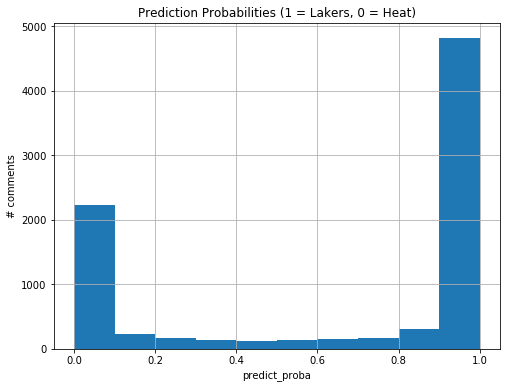

In [469]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

df['predict_proba'].hist(ax=ax)
ax.set_title('Prediction Probabilities (1 = Lakers, 0 = Heat)')
ax.set_ylabel('# comments')
ax.set_xlabel('predict_proba')

plt.show()

So yeah, the model is way too confident in it's predictions. We might as well just look at the
prediction labels and not the prediction probabilities. 

Let's see if we can figure out  what the opinions are by game and such. Do the comments change based on the winner?

In [486]:
comment_counts = df[df['winner']=='Heat']['prediction_name'].value_counts(True) * 100
print('Comment classification in games won by the Heat:\n')
print('\tLakers: {:.1f} %'.format(comment_counts['Lakers']))
print('\tHeat: {:.1f} %'.format(comment_counts['Heat']))

comment_counts = df[df['winner']=='Lakers']['prediction_name'].value_counts(True) * 100
print('\nComment classification in games won by the Lakers:\n')
print('\tLakers: {:.1f} %'.format(comment_counts['Lakers']))
print('\tHeat: {:.1f} %'.format(comment_counts['Heat']))

Comment classification in games won by the Heat:

	Lakers: 67.7 %
	Heat: 32.3 %

Comment classification in games won by the Lakers:

	Lakers: 64.9 %
	Heat: 35.1 %


That seems backwards from what I would have predicted, but maybe the losing team does more complaining.
Or maybe it's just random anyway.

Let's dig into the most frequent commenters and see if we can deduce who they support.

In [527]:
authors = df['author_id'].value_counts()
authors.head(10)

19v1ze      93
xmlcpt2     54
16xpvs      50
2nu9liyg    48
83t5t       44
j7i90       41
ylfg7       38
7xx89       38
tlosp       37
j9wna       37
Name: author_id, dtype: int64

In [562]:
prolific_commenters = authors[authors > 20]

max_heat_pct = 0
max_heat_author = ''
max_lakers_pct = 0
max_lakers_author = ''

for author_id in prolific_commenters.index:
    
    counts = df[df['author_id']==author_id]['prediction_name'].value_counts()
    
    pct_lakers = 100.0 * counts['Lakers'] / authors[author_id]
    pct_heat = 100 - pct_lakers
    
    if pct_lakers > max_lakers_pct:
        max_lakers_pct = pct_lakers
        max_lakers_author = author_id
    
    if pct_heat > max_heat_pct:
        max_heat_pct = pct_heat
        max_heat_author = author_id